In [1]:
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict
import math

%matplotlib inline

In [55]:
#define sigmoid and its derivative for activation & backprop
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def derivSigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

## Question 1 - Import Data

In [56]:
################################################################################
# CSE 253: Programming Assignment 1
# Code snippet by Michael
# Winter 2020
################################################################################
# We've provided you with the dataset in PA1.zip
################################################################################
# To install PIL, refer to the instructions for your system:
# https://pillow.readthedocs.io/en/5.2.x/installation.html
################################################################################
# If you don't have NumPy installed, please use the instructions here:
# https://scipy.org/install.html
################################################################################


''' 
list of face expressions (contempt, neutral are excluded) are:
1. anger
2. disgust
3. fear
4. happiness
5. sadness
6. surprise
'''

def load_data(data_dir="./aligned/"):
	""" Load all PNG images stored in your data directory into a list of NumPy
	arrays.

	Args:
		data_dir: The relative directory path to the CK+ image directory.
	Returns:
		images: A dictionary with keys as emotions and a list containing images associated with each key.
		cnt: A dictionary that stores the # of images in each emotion
	"""
	images = defaultdict(list)

	# Get the list of emotional directory:
	for e in listdir(data_dir):
		# excluding any non-directory files
		if not os.path.isdir(os.path.join(data_dir, e)):
			continue
		# Get the list of image file names
		all_files = listdir(os.path.join(data_dir, e))

		for file in all_files:
			# Load only image files as PIL images and convert to NumPy arrays
			if '.png' in file:
				img = Image.open(os.path.join(data_dir, e, file))
				images[e].append(np.array(img))

	print("Emotions: {} \n".format(list(images.keys())))

	cnt = defaultdict(int)
	for e in images.keys():
		print("{}: {} # of images".format(e, len(images[e])))
		cnt[e] = len(images[e])
	return images, cnt

def balanced_sampler(dataset, cnt, emotions):
	# this ensures everyone has the same balanced subset for model training, don't change this seed value
	random.seed(20)
	print("\nBalanced Set:")
	min_cnt = min([cnt[e] for e in emotions])
	balanced_subset = defaultdict(list)
	for e in emotions:
		balanced_subset[e] = copy.deepcopy(dataset[e])
		random.shuffle(balanced_subset[e])
		balanced_subset[e] = balanced_subset[e][:min_cnt]
		print('{}: {} # of images'.format(e, len(balanced_subset[e])))
	return balanced_subset

def display_face(img):
	""" Display the input image and optionally save as a PNG.

	Args:
		img: The NumPy array or image to display

	Returns: None
	"""
	# Convert img to PIL Image object (if it's an ndarray)
	if type(img) == np.ndarray:
		print("Converting from array to PIL Image")
		img = Image.fromarray(img)

	# Display the image
	img.show()



In [57]:
K = 10 # number of sections after folding
M = 50 # maximum number of epochs


## Training Procedure

In [243]:
# settings

CATEGORIES = ["happiness", "anger"]
EPOCHS = 50
K = 10 # prinsipal components
LOGISTIC = True
LEARNING_RATE = 0.01


In [244]:
# get the data

data_dir = "./resized/"
dataset, cnt = load_data(data_dir)
# test with happiness and anger
images = balanced_sampler(dataset, cnt, emotions=CATEGORIES)
display_index = 0

Emotions: ['happiness', 'anger'] 

happiness: 69 # of images
anger: 45 # of images

Balanced Set:
happiness: 45 # of images
anger: 45 # of images


In [245]:
#list happiness as a 1, anger as a 0
#emotions_mapping = ["fear", "surprise", "sadness", "happiness", "anger", "disgust"]
X = []
y = []
for i, category in enumerate(CATEGORIES):
    X += images[category]
    y += [i] * len(images[category])
    
#get my feature - label pairs zipped together
all_data = list(zip(X,y))

#randomize the dataset so I can fold properly

random.shuffle(all_data)

def kfold(data, k=10):
    folds = []
    size = int((1/k) * len(data))
    for i in range(0,k):
        folds.append(data[i*size : (i+1)*size])
    return folds


In [313]:

def kfold(data, k=3):
    """

    :param data: input data
    :param k: number of folds
    :return: folds
    """
    data = ["x1", "x2", "x3", "z1", "z2", "z3", "y1", "y2", "y3"]
    print(len(data))
    
    fold_size = int((1 / k) * len(data))
    folds = []
    
    cat = 3
    section_size = int(len(data) / cat)
    #print(section_size)
    for i in range(0, len(data)):
        section = i % cat # 0, 1, 0, 1
        section_index = math.floor(i / cat) # 0
        fold_index = math.floor(i / fold_size)
        print(fold_index)
        #print(section)
        if len(folds) == fold_index:
            folds.append([])
        folds[fold_index].append(data[section * section_size + section_index])
        #print(folds) 
    return folds

In [314]:
folds = kfold(all_data)
print(folds)
print(folds[0])
print(folds[0][0])
print(folds[1][1])
print(len(folds[0]) == len(folds[1]))
print(len(folds))

9
0
0
0
1
1
1
2
2
2
[['x1', 'z1', 'y1'], ['x2', 'z2', 'y2'], ['x3', 'z3', 'y3']]
['x1', 'z1', 'y1']
x1
z2
True
3


## Task 5 - Logistic Regression

In [247]:
class LogisticRegression:
    
    def __init__(self, lr, dim):
        self.lr = lr
        self.w = np.ones(dim) 
    
    def stochastic_gradient_descent(self, X, labels):
        indices = [i for i in range(len(labels))]
        np.random.shuffle(indices)
        for i in indices:
            
            # make predition
            data = X[i]
            label = labels[i]
            predicted = sigmoid(data.dot(self.w))
            error = label - predicted
            
            # update weights
            for i in range(len(self.w)):
                grad = error * data[i]
                self.w[i] += self.lr * grad
            
    def probabilities(self, X):
        return sigmoid(X.dot(self.w)).reshape(-1)
    

    def accuracy(self, prob_vec, labels): 
        correct = np.round(prob_vec) == labels
       
        correct = np.sum(correct)
        accuracy = correct / len(labels)
        return accuracy

    
    def batch_gradient_descent(self, X, labels):
        predicted = self.probabilities(X)
        error = labels - predicted
        grad = X.T.dot(error)
        self.w += self.lr * grad
        

    def loss(self, labels, predicted):
        #cost = np.log(predicted+ 0.0001) * labels + (1 - labels) * np.log(1 - predicted)
        #return - cost.sum() / len(labels)
        #print(cost)
        
        Yis1 = labels == 1
        cost = -(np.log(predicted[Yis1]).sum() + np.log(1 - predicted[~Yis1]).sum())/len(labels)
        return cost

In [248]:
lr = LogisticRegression(0.1, 3)

In [249]:
lr.loss(np.array([1,1]), np.array([1,1]))

-0.0

In [250]:
lr.loss(np.array([1,1]), np.array([0.8,1]))

0.11157177565710485

In [251]:
test_data = np.array([[0.9,0.22,0.44], [0.0,0.22,0.44]])

for i in range(50):
    lr.stochastic_gradient_descent(test_data, np.array([0, 1]))

In [252]:
lr.w

array([-1.40913024,  0.82624216,  0.65248432])

In [253]:
lr.probabilities(test_data)

array([0.3101644 , 0.61511541])

In [254]:
lr.loss(np.array([0, 1]), lr.probabilities(test_data))

0.42862367125937445

In [255]:
5 

[0, 0, 0, 0, 1, 0]

[0, 0, 0, 0, 1, 0]

## Softmax

In [256]:
class SoftmaxRegression:
    
    def __init__(self, lr, dim, c):
        self.lr = lr
        self.c = c
        self.w = np.ones((dim, c)) 
    
    def stochastic_gradient_descent(self, X, labels):
        indices = [i for i in range(len(labels))]
        np.random.shuffle(indices)
        for i in indices:
            
            # make predition
            data = X[i]
            label = labels[i]
            predicted = self.probabilities(data)
            error = label - predicted
            
            # update weights
            for i in range(len(self.w)):
                grad = error * data[i]
                self.w[i] += self.lr * grad
            
    def probabilities(self, X):
        return np.exp(X.dot(self.w)) / np.sum(np.exp(X.dot(self.w)), axis=1).reshape(len(X),1)

    
    def batch_gradient_descent(self, X, labels):
        predicted = self.probabilities(X)
        error = labels - predicted
        grad = X.T.dot(error)
        self.w += self.lr * grad
        

    def accuracy(self, prob_vec, labels): #prob_vec row is probabilities of a single instance
        numer = 0
        denom = len(labels)
        for i in range(len(labels)):
            y = list(prob_vec[i]).index(max(prob_vec[i]))
            t = list(labels[i]).index(max(labels[i]))
            if y == t:
                numer += 1
        accuracy = numer / denom
        return accuracy
    
    def visualize_weights(self, pca):
        visualized = pca.components.dot(self.w).T.reshape((self.c, -1))
        imgs_data = [img.reshape(224, 192) for img in visualized]
        for img in imgs_data:
            plt.imshow(img, cmap="gray")
            plt.show()
    
    def loss(self, labels, predicted):
        #return -np.sum(np.sum(labels.T.dot(np.log(predicted)))) # can't have zero values 
        sum_of_score = 0
        for n in range(predicted.shape[0]):
            for cat in range(self.c):
                sum_of_score += labels[n, cat] * np.log(predicted[n, cat])

        return - sum_of_score / predicted.shape[0]


In [257]:
softmax = SoftmaxRegression(0.02, 4, 2)

test_data = np.array([[0.3,0.22,0.44, 0.44], [0.0,0.12,0.2, 0.2], [0.1,0.4,0.4, 0.6]])



#softmax.loss(np.array([[1, 0],[1,0]]), softmax.probabilities(test_data))

In [258]:
softmax.loss(np.array([[1, 0],[1, 0], [1,0]]), np.array([[0.99,0.01], [0.99,0.01], [0.95,0.05]]))

0.023797988698184492

In [259]:
for i in range(50):
    softmax.batch_gradient_descent(test_data, np.array([[1, 0], [1, 0],[0,0]]))

In [260]:
softmax.w

array([[1.07005754, 0.82994246],
       [0.91831769, 0.68168231],
       [1.04982869, 0.55017131],
       [0.93383126, 0.46616874]])

In [261]:
class PCA:
    def __init__(self, square_data, k=10): # k defaults to 10
        self.square_data = square_data
        M, rows, columns = self.square_data.shape
        self.k = k
        self.num_examples = M
        self.image_vec = np.reshape(square_data, (M, rows*columns))
        self.mean_face = np.mean(self.image_vec, axis=0)
        self.std_face = np.std(self.image_vec, axis=0)
        self.components, self.singular_values = self.get_components()
    
    def get_components(self):
        Phi = (self.image_vec - self.mean_face) / self.std_face 
        A = Phi
        C = np.matmul(A, A.T)
        C = np.divide(C, self.num_examples - 1)
        evals, Vi = np.linalg.eigh(C)
        z = list(zip(evals,Vi))
        z.sort(reverse=True)        
        
        idx = np.argsort(evals)[::-1]
        evecs = Vi[:, idx]
        evecs = evecs[:, :self.k]
        pc = evecs
        
        #final components (num pixels by k matrix)
        components = np.matmul(A.T, pc)
        components = components / np.linalg.norm(components, axis=0)
        #get singluar values
        sorted_evals = np.array([x[0] for x in z])
        postive_evals = sorted_evals[:self.k]
        singular_values = np.sqrt(postive_evals.reshape(1, -1))
        assert np.allclose(np.linalg.norm(components, axis=0), 1)

        return components, singular_values
        
    def transform(self, images):
        return np.array([self.transform_single(i) for i in images])
        
    def transform_single(self, image): #take an image, and pc's, and output compressed image
        image =  image.reshape(1, -1) 
        image = (image - self.mean_face) / self.std_face
        compressed_image_vectors = np.matmul(image, self.components) / self.singular_values
        return compressed_image_vectors.reshape(-1,)

2
3
4
5
6
7
8
9


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


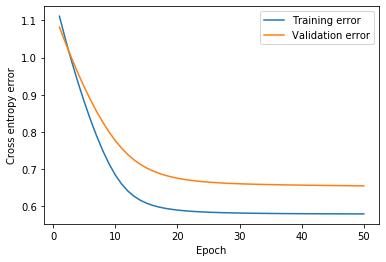

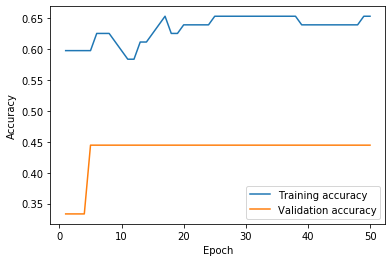

0
3
4
5
6
7
8
9


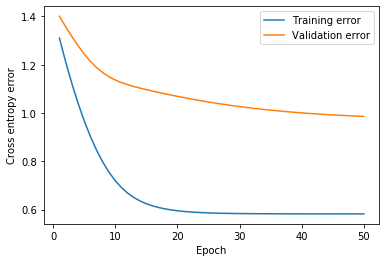

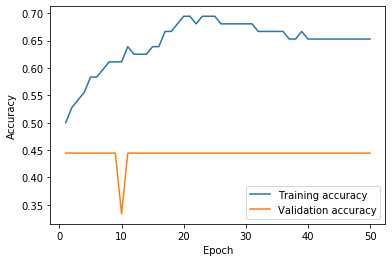

0
1
4
5
6
7
8
9


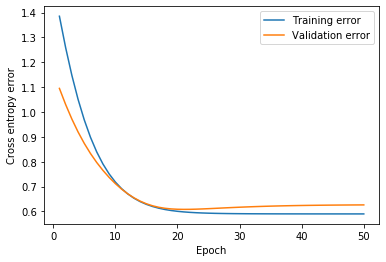

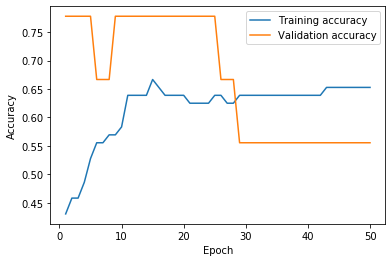

0
1
2
5
6
7
8
9


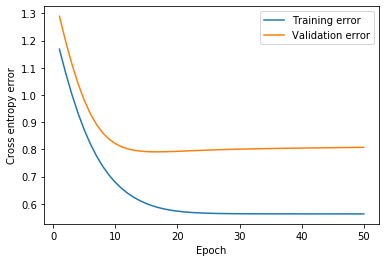

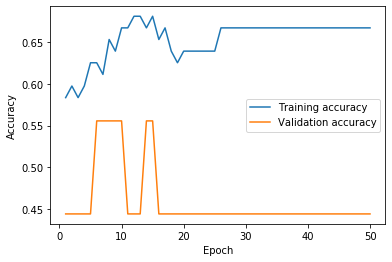

0
1
2
3
6
7
8
9


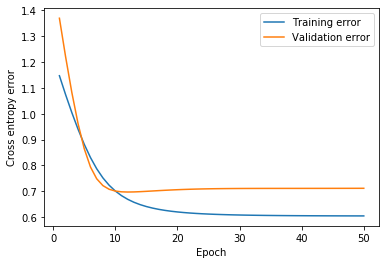

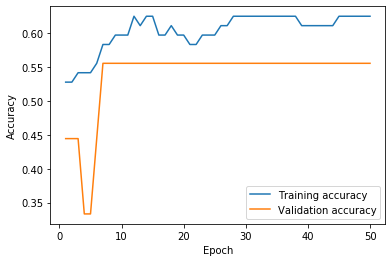

0
1
2
3
4
7
8
9


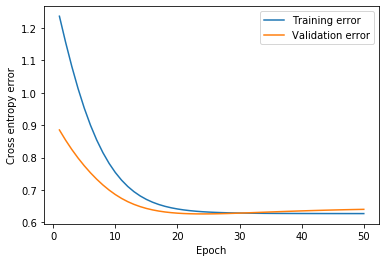

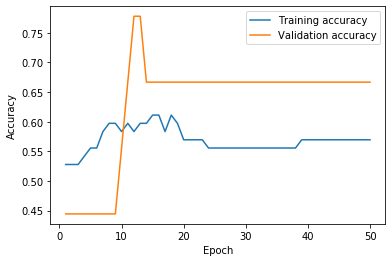

0
1
2
3
4
5
8
9


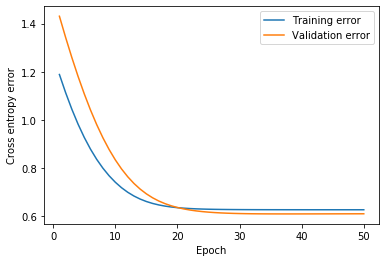

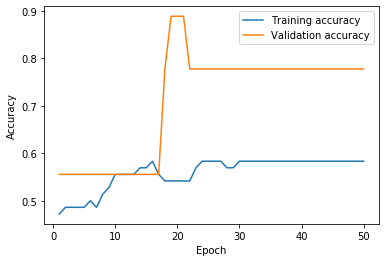

0
1
2
3
4
5
6
9


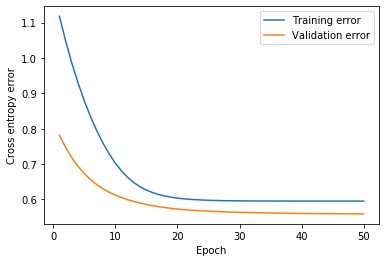

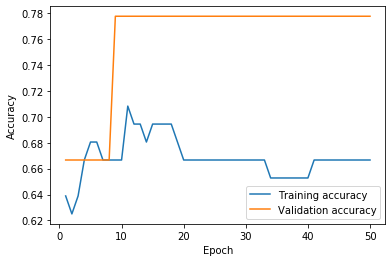

0
1
2
3
4
5
6
7


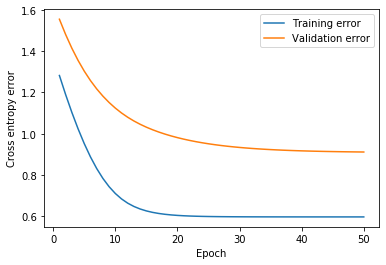

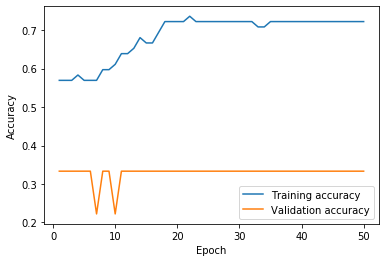

1
2
3
4
5
6
7
8


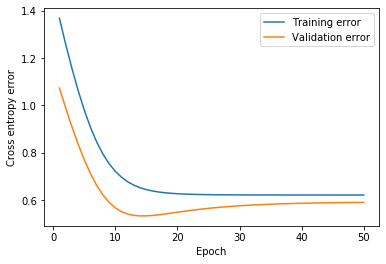

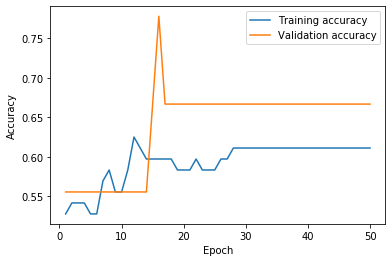

variation
[0.65520217 0.98572743 0.62627778 0.80769034 0.71128234 0.6405153
 0.60999937 0.55908247 0.91051044 0.59075806]
0.13697059137224232


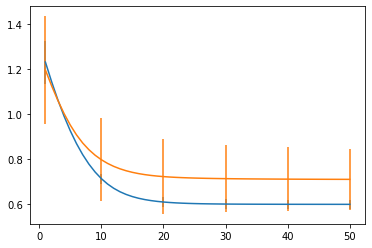

In [262]:
import matplotlib.pyplot as plt
#from pca import PCA

class EpochData:
    def __init__(self):
        self.acc = []
        self.error = []
    
    def save(self, error, acc):
        self.error.append(error)
        self.acc.append(acc)
        
    def add(self, epoch_data):
        self.error.append(epoch_data.error)
        
    def align(self, k):
        self.error = np.array(self.error).reshape((k, EPOCHS))
       
    def score(self):
        return self.error[-1]
        
        
def transform(pca, data):
    labels = data[1]
    if not LOGISTIC: # if softmax
        labels = one_hot_encode(labels)
    return pca.transform(data[0]), labels
    #np.array([pca.transform(i)[0] for i in data[0]]), labels

def visualize_data(plots, legends, x_label, y_label):
    x = np.arange(1, len(plots[0]) + 1)
    for data in plots:
        plt.plot(x, data)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(legends)
    plt.show()
    
def visualize_data_avg(train_data, val_data):
    x = np.arange(1, len(train_data.error[0]) + 1)
    for data in [train_data.error, val_data.error]:
        mean = np.sum(data, axis=0)/data.shape[0] # divide by folds
        x_std = []
        y_std = []
        
        for i in range(0, 50):
            if (i+1) % 10 == 0 or i == 0:
                y_std.append(np.std(data[:, i]))
            else:
                y_std.append(0)
        plt.errorbar(np.arange(1, 50 + 1, 1), mean, y_std)
    plt.show()
    
def split_x_y(data):
    return np.array([item[0] for item in data]), np.array([item[1] for item in data]) 

def one_hot_encode(labels):
    new_labels = np.zeros((len(labels), len(CATEGORIES)))
    new_labels[np.arange(labels.size), labels] = 1
    return new_labels

def train():
    best_model = None
    
    folds = kfold(all_data)
    avg_epoch_data_train = EpochData()
    avg_epoch_data_val = EpochData()
    
    
    k = len(folds)
    for fold in range(k):
        # define the model
        if LOGISTIC:
            model = LogisticRegression(LEARNING_RATE, K)
        else:
            model = SoftmaxRegression(LEARNING_RATE, K, len(CATEGORIES))

        # split data
        val_data, test_data = split_x_y(folds[fold]), split_x_y(folds[(fold + 1) % k])
        train_data = None
        for i in range(k):
            if i != fold and i != ((fold + 1) % k):
                print(i)
                if train_data is None:
                    train_data = folds[i]
                else:
                    train_data = np.concatenate((train_data, folds[i]))
        train_data = split_x_y(train_data)
        
        pca = PCA(train_data[0], K)
        
        # PCA and one_hot
        train_data, test_data, val_data = transform(pca, train_data), transform(pca, test_data), transform(pca, val_data)        
        validation_performance = EpochData()
        training_performance = EpochData() 
        
        assert not (any([val_img in train_data for val_img in val_data]))


        
        for epoch in range(EPOCHS):
            model.batch_gradient_descent(train_data[0], train_data[1])
            


            train_prob = model.probabilities(train_data[0])
            val_prob = model.probabilities(val_data[0])
            
            training_error = model.loss(train_data[1], train_prob)
            validation_error = model.loss(val_data[1], val_prob)
            
            traning_acc = model.accuracy(train_prob, train_data[1])
            validation_acc = model.accuracy(val_prob, val_data[1])
            
            #print("Training error: {}, validation error: {}, accuracy: {}".format(training_error, validation_error, traning_acc))
        
            # save
            validation_performance.save(validation_error, validation_acc)
            training_performance.save(training_error, traning_acc)
        
        
        # plot the graphs
        data_to_plot = [training_performance.error, validation_performance.error]
        legends = ["Training error", "Validation error"]
        visualize_data(data_to_plot, legends, "Epoch", "Cross entropy error")
        
        data_to_plot = [training_performance.acc, validation_performance.acc]
        legends = ["Training accuracy", "Validation accuracy"]
        visualize_data(data_to_plot, legends, "Epoch", "Accuracy")
                
        # save the validation data to the model
        model.epoch_data = validation_performance 
        avg_epoch_data_train.add(training_performance)
        avg_epoch_data_val.add(validation_performance)

        # save the best model
        if best_model is None:
            best_model = model
        elif best_model.epoch_data.score() > model.epoch_data.score():
            best_model = model
        
    avg_epoch_data_train.align(10)
    avg_epoch_data_val.align(10)

    print("variation")
    print(avg_epoch_data_val.error[:, -1])
    print(np.std(avg_epoch_data_val.error[:, -1]))

    
    visualize_data_avg(avg_epoch_data_train, avg_epoch_data_val)
    if not LOGISTIC:
        best_model.visualize_weights(pca)
            

train()


In [242]:
softmax.probabilities(test_data)

array([[0.63406948, 0.36593052],
       [0.55523866, 0.44476134],
       [0.64545635, 0.35454365]])

In [221]:
test_data = np.array([
    [[40, 33, 34], 
     [54, 34, 22]],
    
    [[34, 40, 34], 
     [23, 32, 32]],

    [[60, 30, 64], 
     [73, 62, 72]]])

test_img = np.array([[34, 36, 45], [34, 36, 45]])

In [222]:
pca = PCA2(np.array(test_data), 1)

NameError: name 'PCA2' is not defined

In [ ]:
pca.transform_single(test_img)

In [ ]:
print(pca.components)

In [ ]:
print(pca.singular_values)

In [ ]:
from pca import PCA

pca1 = PCA(1)

In [ ]:
pca1.fit(test_data)

In [ ]:
pca1.transform(test_img)

In [ ]:
print(pca1.p_components)

In [ ]:
print(pca1.s_vals)

In [ ]:
def logistic_accuracy(prob_vec, labels): 
    correct = np.round(prob_vec) == labels
    correct = np.sum(correct)
    accuracy = correct / len(labels)
    return accuracy

def softmax_accuracy(prob_vec, labels): #prob_vec row is probabilities of a single instance
    numer = 0
    denom = len(labels)
    for i in range(len(labels)):
        y = prob_vec[i].index(max(prob_vec[i]))
        t = labels[i].index(max(labels[i]))
        if y == t:
            numer += 1
    accuracy = numer / denom
    return accuracy


print(logistic_accuracy(logistic_prob_vec, logistic_labels))
print(softmax_accuracy(softmax_prob_vec, softmax_labels))

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(, cmap="gray")